In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


In [62]:
def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped
                  
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def color_thresh_rock(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)

    # threshold for hue channel in blue range
    yellow_min = np.array([20, 190, 20], np.uint8)
    yellow_max = np.array([30, 255, 255], np.uint8)
    threshold_yellow_img = cv2.inRange(hsv, yellow_min, yellow_max)

    threshold_img = cv2.cvtColor(threshold_yellow_img, cv2.COLOR_GRAY2RGB)
    #color_select = np.zeros_like(img[:,:,0])
    #within_thresh = (img[:,:,0] > 130) \
     #           & (img[:,:,0] < 205) \
      #          & (img[:,:,1] > 100) \
       #         & (img[:,:,1] < 180) \
        #        & (img[:,:,2] < 60)
    #plt.imshow(threshold_img)
    return threshold_img
    #color_select[within_thresh] = 1
    #return color_select
    
def color_thresh_obstacle(img):
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] < 160) \
                & (img[:,:,1] < 160) \
                & (img[:,:,2] < 160)

    color_select[above_thresh] = 1
    return color_select
    
#image = mpimg.imread('sample.jpg')
image = mpimg.imread('rock.jpg')
image = mpimg.imread('obstacle.jpg')
#image = cv2.imread('rock.jpg')
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])


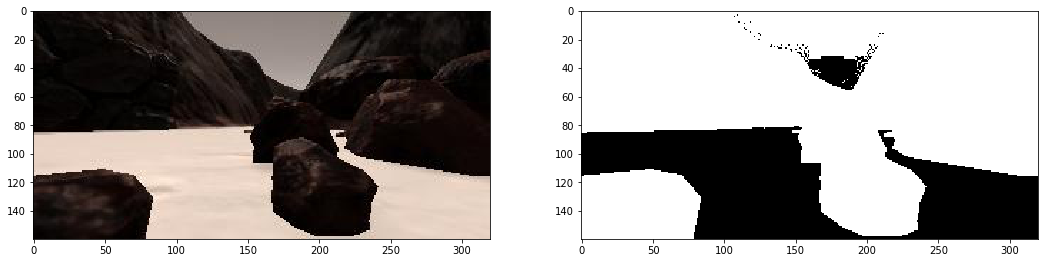

In [63]:

# Read in the sample image
#image = mpimg.imread('sample.jpg')
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Perform warping and color thresholding
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
colorsel_rock = color_thresh_rock(image)
colorsel_obstacle = color_thresh_obstacle(image)
# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
#xpix, ypix = rover_coords(colorsel)


###xpix, ypix = rover_coords(colorsel_rock)

# Plot the map in rover-centric coords
###fig = plt.figure(figsize=(5, 7.5))
###plt.plot(xpix, ypix, '.')
###plt.ylim(-160, 160)
###plt.xlim(0, 160)
#plt.imshow(colorsel_rock)
#plt.title('Rover-Centric Map', fontsize=20)
#plt.show() # Uncomment if running on your local machine

fig = plt.figure(figsize=(18,8)) # Create a figure for plotting
plt.subplot(121) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(image)  # Plot the green channel
plt.subplot(122) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(colorsel_obstacle, cmap='gray')  # Plot the blue channel
plt.show()

Xpos = [ 94.17374657] Ypos = [ 132.1554349] Yaw = [ 196.78557403]


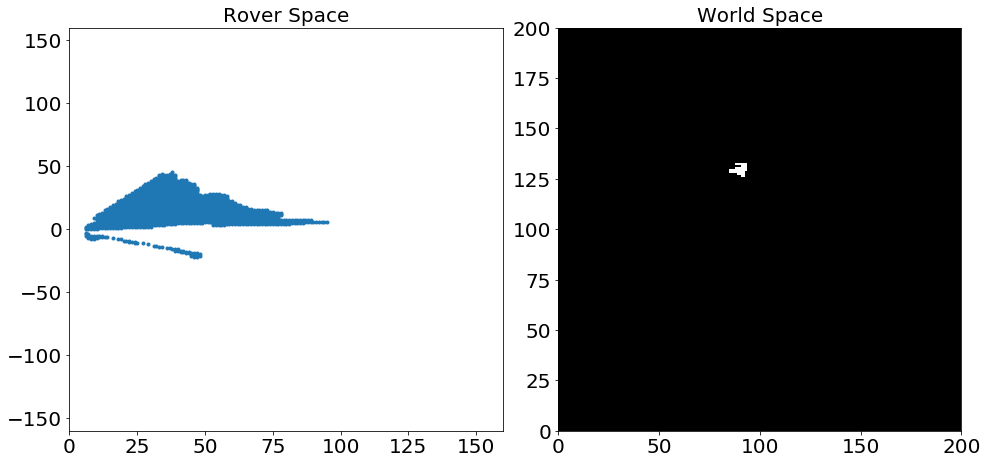

In [64]:
# Read in the sample image
#image = mpimg.imread('sample.jpg')

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# No need to modify code below here
# Perform warping and color thresholding
##########
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=20)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=20)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show() # Uncomment if running on your local machine

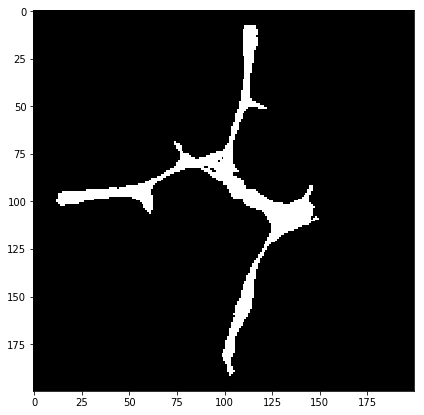

1.0
40000
(200, 200)


In [140]:
robot_map = mpimg.imread('map_bw.png')
plt.figure(figsize=(14, 7))
plt.imshow(robot_map,cmap='gray')

plt.show()
print(robot_map[100,13])
print(robot_map.size)
print(robot_map.shape)

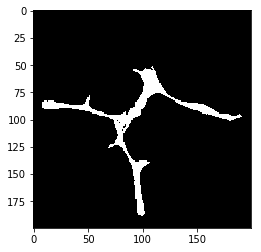

In [141]:
rows,cols = robot_map.shape

M = cv2.getRotationMatrix2D((cols/2,rows/2),90,1)
robot_map = cv2.warpAffine(robot_map,M,(cols,rows))
plt.imshow(robot_map,cmap='gray')

plt.show()

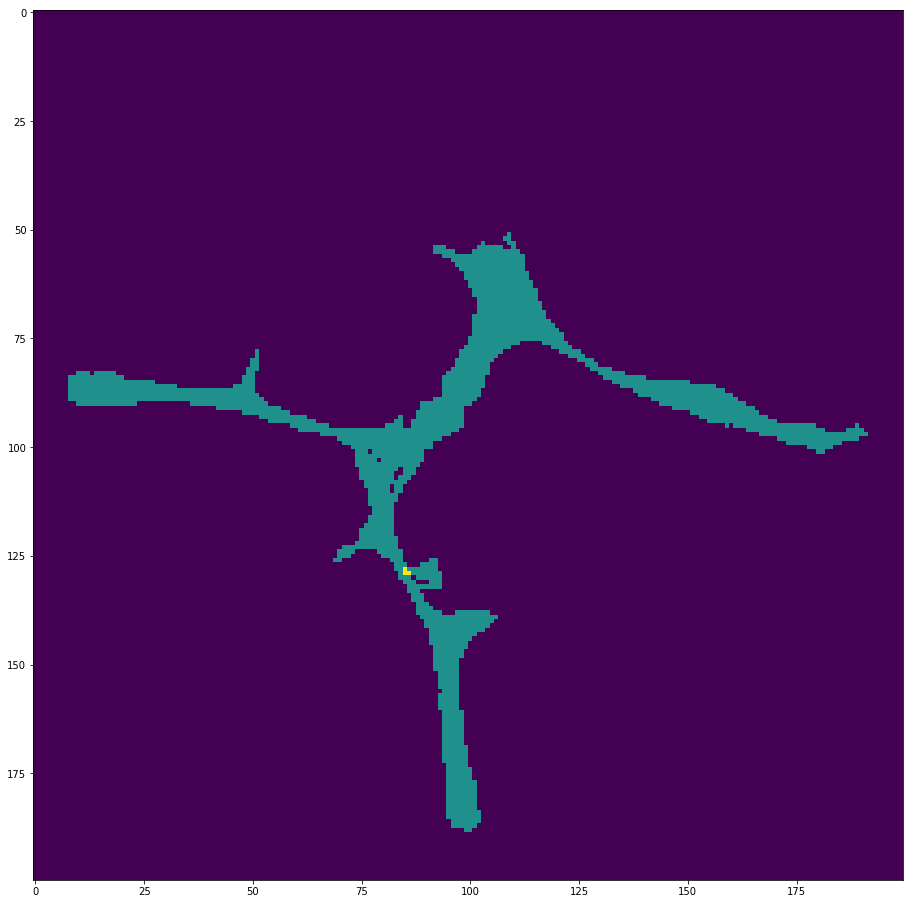

In [143]:
radar_map = robot_map + worldmap
plt.figure(figsize=(16, 16))
plt.imshow(radar_map)

plt.show()


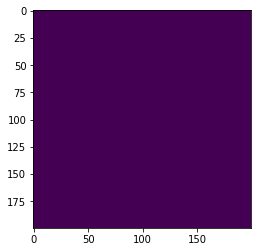

(200, 200)


In [106]:
#def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
color_select = np.zeros((robot_map.shape[0], robot_map.shape[1]))
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
#above_thresh = (img[:,:,0] > rgb_thresh[0]) \
       #         & (img[:,:,1] > rgb_thresh[1]) \
        #        & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
#    color_select[above_thresh] = 1
    # Return the binary image
#    return color_select
plt.imshow(color_select)
plt.show()
print(color_select.shape)

In [116]:
color_select[50:70,50:70] = 1

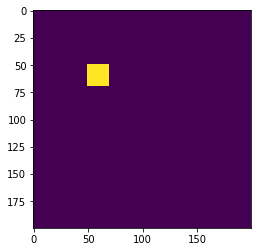

In [117]:
plt.imshow(color_select)
plt.show()